# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果

In [1]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
from tensorflow.keras import optimizers


In [2]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [3]:

'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 

batch_size = 64
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'


In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 1015s 6us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [6]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [7]:
# 輸出模型摘要資訊
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [8]:
#第三步編譯
'''
SGD(隨機梯度下降) - Arguments
lr: float >= 0. Learning rate.
momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
decay: float >= 0. Learning rate decay over each update.
nesterov: boolean. Whether to apply Nesterov momentum.
'''

'''
RMSprop- Arguments
lr: float >= 0. Learning rate.
rho: float >= 0.
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
decay: float >= 0. Learning rate decay over each update.
'''

'''
Example:
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

'''

opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [9]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [10]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)   

'''
   第四步：訓練
   .fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
''' 
    

Using real-time data augmentation.



W0717 09:40:36.834426 139959364708160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 61s 1ms/sample - loss: 1.8415 - accuracy: 0.3227 - val_loss: 1.4657 - val_accuracy: 0.4693
Epoch 2/20
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.3706 - accuracy: 0.5053 - val_loss: 1.1745 - val_accuracy: 0.5678
Epoch 3/20
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.1671 - accuracy: 0.5841 - val_loss: 1.0385 - val_accuracy: 0.6295
Epoch 4/20
50000/50000 [==============================] - 60s 1ms/sample - loss: 1.0335 - accuracy: 0.6331 - val_loss: 0.9115 - val_accuracy: 0.6842
Epoch 5/20
50000/50000 [==============================] - 60s 1ms/sample - loss: 0.9298 - accuracy: 0.6712 - val_loss: 0.8239 - val_accuracy: 0.7118
Epoch 6/20
50000/50000 [==============================] - 60s 1ms/sample - loss: 0.8633 - accuracy: 0.6938 - val_loss: 0.7968 - val_accuracy: 0.7237
Epoch 7/20
50000/50000 [==============================] 

'\n   第四步：訓練\n   .fit的一些參數\n   batch_size：對總的樣本數進行分組，每組包含的樣本數量\n   epochs ：訓練次數\n   shuffle：是否把數據隨機打亂之後再進行訓練\n   validation_split：拿出百分之多少用來做交叉驗證\n   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果\n'

In [11]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, "%d_%d_%s" % (batch_size, epochs, model_name))
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /tf/homework/saved_models/64_20_keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 2s 250us/sample - loss: 0.6020 - accuracy: 0.7971
Test loss: 0.6019958617210388
Test accuracy: 0.7971


In [12]:
#    第六步：輸出
import numpy 

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)


result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)


 test set 

 The test loss is %f  [0.6019958573579788, 0.7971]


In [13]:
print(result)
print(result_max, test_max)
print(result_bool, true_num)

[[6.52075032e-05 5.01991417e-05 6.94558039e-05 ... 4.62835596e-05
  4.45363257e-04 4.51385968e-05]
 [2.69950579e-05 2.69925105e-03 8.76089294e-14 ... 1.56443798e-15
  9.97258782e-01 1.49646376e-05]
 [6.66142106e-02 1.76381264e-02 3.96487667e-06 ... 4.99269277e-07
  9.12281871e-01 3.44911846e-03]
 ...
 [1.28199617e-05 1.07434334e-06 5.13941934e-03 ... 1.14979006e-01
  3.89314810e-05 1.01660837e-04]
 [1.15432926e-02 5.42118609e-01 5.32866223e-03 ... 5.32446662e-04
  1.34981301e-05 1.19272685e-02]
 [2.54179056e-09 3.60462882e-09 1.62206379e-06 ... 9.98990238e-01
  6.97346833e-11 5.69943592e-10]]
[3 8 8 ... 5 1 7] [3 8 8 ... 5 1 7]
[ True  True  True ...  True  True  True] 7971


In [16]:
history.history

{'loss': [1.8415445626831055,
  1.3706307182693482,
  1.167144870071411,
  1.0335446200561524,
  0.9297680196380615,
  0.8633226885032654,
  0.807940330619812,
  0.761401368932724,
  0.727387668876648,
  0.6915537647247314,
  0.6637981965637207,
  0.6353275075531006,
  0.6146165711402893,
  0.584092195186615,
  0.5640074729347229,
  0.5471321154785156,
  0.5393731728363037,
  0.5132943872261048,
  0.5080058942985535,
  0.4904594176483154],
 'accuracy': [0.32274,
  0.5053,
  0.58408,
  0.63314,
  0.67122,
  0.69378,
  0.71436,
  0.73088,
  0.74366,
  0.75702,
  0.76744,
  0.77888,
  0.78436,
  0.79446,
  0.80022,
  0.80446,
  0.81002,
  0.81932,
  0.82116,
  0.82562],
 'val_loss': [1.4656833755493164,
  1.1744992179870606,
  1.0385367639541625,
  0.911541466140747,
  0.823906383228302,
  0.7968306425094605,
  0.785113431930542,
  0.6931998989105225,
  0.7525906825065612,
  0.6936283194065094,
  0.6598994062423706,
  0.6505732130050659,
  0.6489830534458161,
  0.6361561841011047,
  0.603

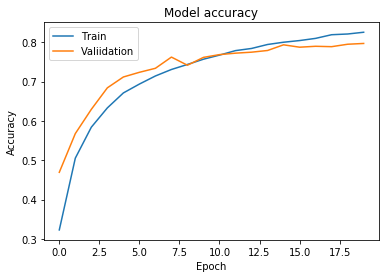

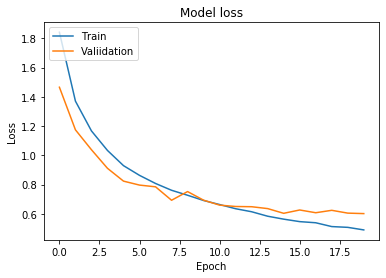

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()